## Credit Risk Modeling--Logistic Regression
data source: https://www.lendingclub.com/info/download-data.action

1) The purpose:in this work, I want to practice developing a classic model of credit risk, which is loan default model;

2) The whole process would be data cleaning,convert and re-coding some variables,hypothesis testing, and stats summary; 

3) Finally, there would be a logistics regression and some insights.

### 1.0 Load Packages and Review the dataset

In [632]:
#install.packages("gmodels", dependencies=TRUE,repos='http://cran.rstudio.com/')
#https://CRAN.R-project.org/package=gmodels
#install.packages("chron", dependencies=TRUE,repos='http://cran.rstudio.com/')

In [24]:
library(dplyr)
library(tidyr)
library(readr)
library(magrittr)
library(ggplot2)
library("IRdisplay")
library(gmodels)
library(chron)

In [634]:
loan_data<-read.csv('C:/Users/Xavier/Desktop/loanfull.csv')

#### when first looking thru the dataset, I found it is a large dataset(100Mb+), and has too many irrelevant info, so I decided to process the data, and do some clean-up

In [635]:
print.data.frame(head(loan_data,5))
ncol(loan_data)
#cuz the head function won't display all cols, I prefer print
#dataset contains 74 columns

       id member_id loan_amnt funded_amnt funded_amnt_inv       term int_rate
1 1077501   1296599      5000        5000            4975  36 months    10.65
2 1077430   1314167      2500        2500            2500  60 months    15.27
3 1077175   1313524      2400        2400            2400  36 months    15.96
4 1076863   1277178     10000       10000           10000  36 months    13.49
5 1075358   1311748      3000        3000            3000  60 months    12.69
  installment grade sub_grade emp_length home_ownership annual_inc
1      162.87     B        B2  10+ years           RENT      24000
2       59.83     C        C4     1 year           RENT      30000
3       84.33     C        C5  10+ years           RENT      12252
4      339.31     C        C1  10+ years           RENT      49200
5       67.79     B        B5     1 year           RENT      80000
  verification_status issue_d loan_status pymnt_plan zip_code addr_state   dti
1            Verified  Dec-11  Fully Paid          

[1] 74

#### 'desc' and 'url' col contains too many texts, and causes view distraction, so I decide to drop it first

In [636]:
ncol(loan_data)
loan_data<-subset(loan_data,select=-c(desc,url))
ncol(loan_data)

[1] 74

[1] 72

In [637]:
summary(loan_data)
# found too much NAs in some certain cols

       id             member_id          loan_amnt      funded_amnt   
 Min.   :   54734   Min.   :   70473   Min.   :  500   Min.   :  500  
 1st Qu.: 9206643   1st Qu.:10877134   1st Qu.: 8000   1st Qu.: 8000  
 Median :34433267   Median :37095283   Median :13000   Median :13000  
 Mean   :32465133   Mean   :35001825   Mean   :14755   Mean   :14742  
 3rd Qu.:54908135   3rd Qu.:58471347   3rd Qu.:20000   3rd Qu.:20000  
 Max.   :68617057   Max.   :73544841   Max.   :35000   Max.   :35000  
                                                                      
 funded_amnt_inv         term           int_rate      installment     
 Min.   :    0    36 months:621125   Min.   : 5.32   Min.   :  15.67  
 1st Qu.: 8000    60 months:266254   1st Qu.: 9.99   1st Qu.: 260.70  
 Median :13000                       Median :12.99   Median : 382.55  
 Mean   :14702                       Mean   :13.25   Mean   : 436.72  
 3rd Qu.:20000                       3rd Qu.:16.20   3rd Qu.: 572.60  
 Max. 

### 1.1 Data Cleaning--Drop cols

#### Re-order the dependent var to the 1st column

In [638]:
#because the loan_status is dependent var, I want to reorder the cols to place the loan_status as the first col
grep("loan_status", colnames(loan_data))  #get the col index

[1] 16

In [639]:
loan_data<-loan_data[c(16,1:33)]
grep("loan_status", colnames(loan_data))

[1]  1 17

In [640]:
loan_data[c(17)]<-NULL #drop the duplicate cols 'loan_status'

#### Drop the cols with too many NAs, first we select 90% as the judgement, and then 50%

In [641]:
col.needdrop=colnames(loan_data)[colSums(is.na(loan_data)) > nrow(loan_data)*0.9]
loan_data <- loan_data %>% select(-one_of(col.needdrop))

In [642]:
colnames(loan_data)[colSums(is.na(loan_data)) > nrow(loan_data)*0.5]

[1] "mths_since_last_delinq" "mths_since_last_record"

In [643]:
col.drop2=colnames(loan_data)[colSums(is.na(loan_data)) > nrow(loan_data)*0.5]
loan_data <- loan_data %>% select(-one_of(col.drop2))
#drop cols with 50% NAs

In [644]:
mylist=colnames(loan_data)
mylist

[1] "loan_status"         "id"                  "member_id"          
 [4] "loan_amnt"           "funded_amnt"         "funded_amnt_inv"    
 [7] "term"                "int_rate"            "installment"        
[10] "grade"               "sub_grade"           "emp_length"         
[13] "home_ownership"      "annual_inc"          "verification_status"
[16] "issue_d"             "pymnt_plan"          "zip_code"           
[19] "addr_state"          "dti"                 "delinq_2yrs"        
[22] "earliest_cr_line"    "inq_last_6mths"      "open_acc"           
[25] "pub_rec"             "revol_bal"           "revol_util"         
[28] "total_acc"           "initial_list_status" "out_prncp"          
[31] "out_prncp_inv"

#### Drop the columns with 'inv' indicating the investor,'d' day,'rec' record; those cols have very few info related to loan default or not

In [645]:
inv=grep('_inv', mylist, value=TRUE)
#select cols with _inv
d=grep('_d', mylist, value=TRUE)
rec=grep('_rec', mylist, value=TRUE)
inv;d;rec

[1] "funded_amnt_inv" "out_prncp_inv"

[1] "issue_d"

[1] "pub_rec"

In [646]:
loan_data <- loan_data %>% select(-one_of(inv,d,rec))

In [647]:
ncol(loan_data)

[1] 27

#### Notice that funded_amt and loan_amt have many identical values, I want to drop one col if they are fully identical; if not, drop the records in which the loan is not fully funded

In [648]:
head(dup<-loan_data[,c('funded_amnt','loan_amnt')],5)

funded_amnt,loan_amnt
5000,5000
2500,2500
2400,2400
10000,10000
3000,3000


In [649]:
identical(loan_data$funded_amnt,loan_data$loan_amnt)

[1] FALSE

In [650]:
nrow(loan_data[duplicated(dup),])
nrow(loan_data)
nrow(loan_data[!duplicated(dup),])
#duplicated function returns the row number that two cols values are equal

[1] 884323

[1] 887379

[1] 3056

In [651]:
loan_data<-loan_data[duplicated(dup),]
#now, the identical rows remain in the dataset in which two cols having same values

In [652]:
nrow(loan_data)

[1] 884323

In [653]:
loan_data<-subset(loan_data,select=-c(funded_amnt))
#https://www.youtube.com/watch?v=KXSPxjjS8Fc

#### By looking at the summary cell again, I found that 99% of payment plan col records are 'no', I would first drop rows with 'yes' and then drop the col

In [654]:
loan_data<-subset(loan_data,pymnt_plan=='n',select=-c(pymnt_plan))
#this func means we select rows meet condition pymnt plan is no, and cols meet condition write off pymnt plan col
#use subset function to select some cells meeting certain conditions like 'where' in sql

In [655]:
nrow(loan_data)

[1] 884313

### 1.2 Data Cleaning--Listwise delete rows with null value

In [656]:
loan_data<-loan_data[complete.cases(loan_data), ]

In [657]:
nrow(loan_data)

[1] 883815

### 2.1 Data Processing--Coding Loan status

#### First understand the economics meaning of several levels under loan_status

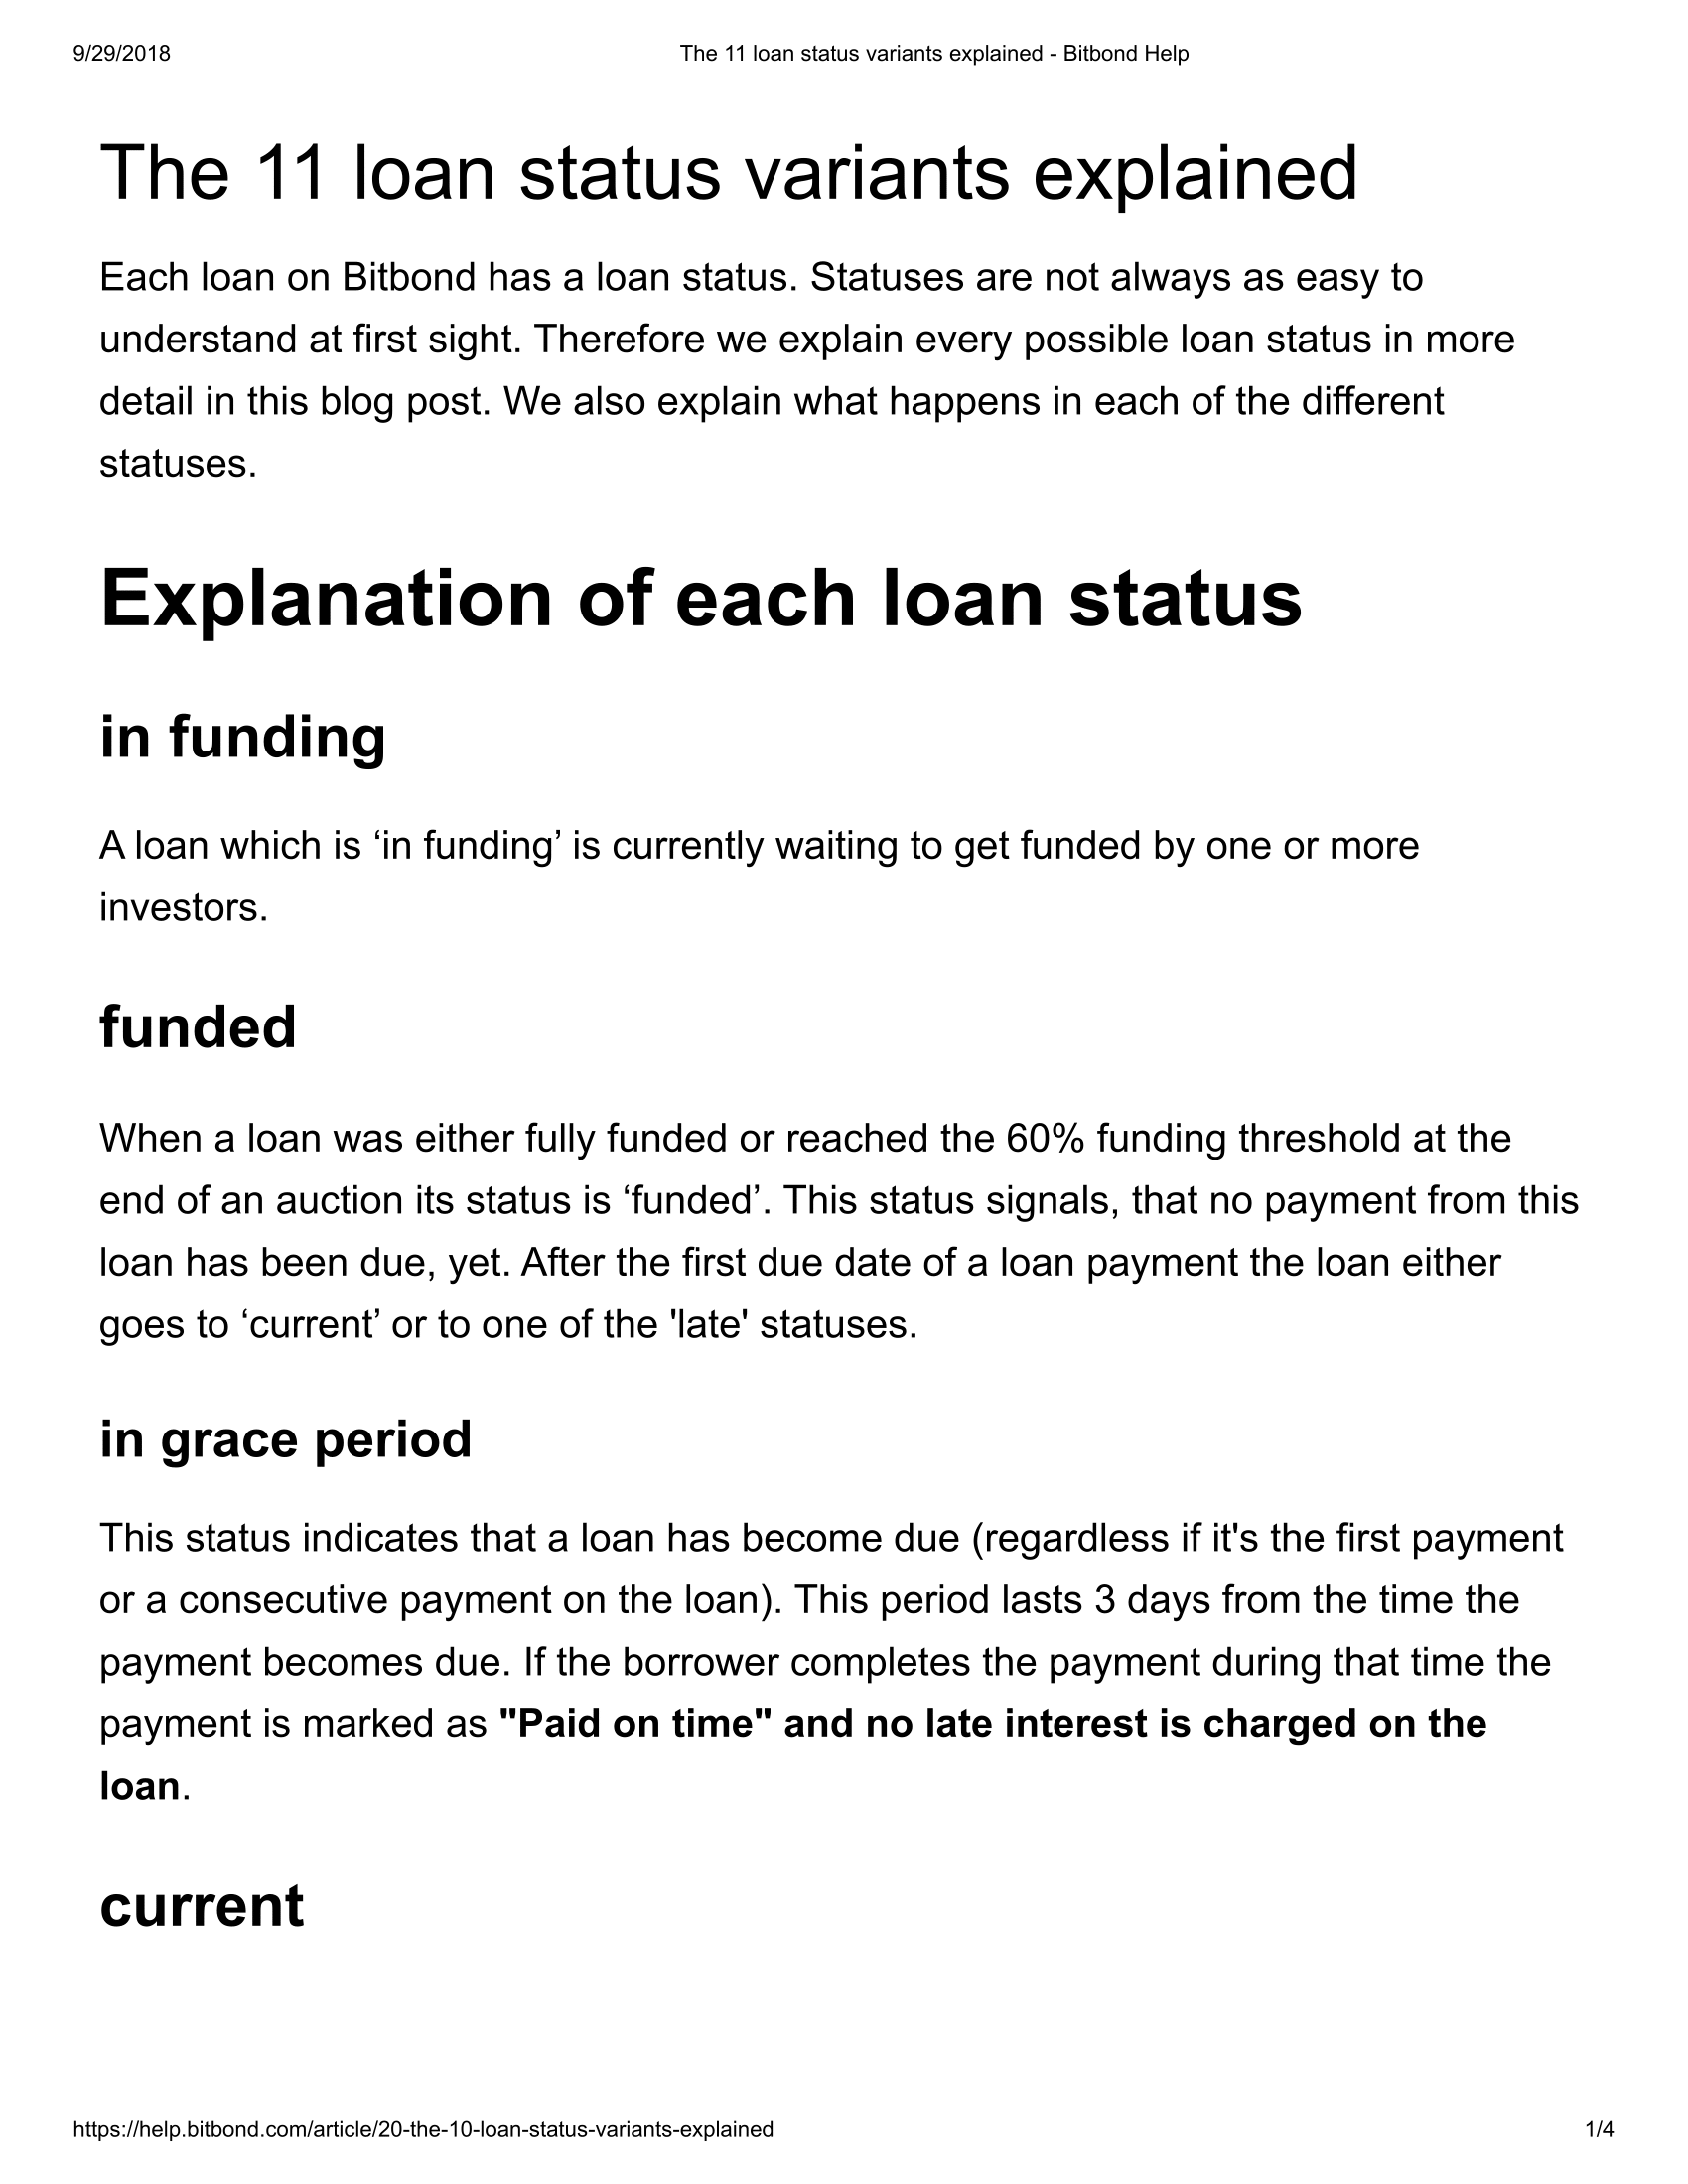

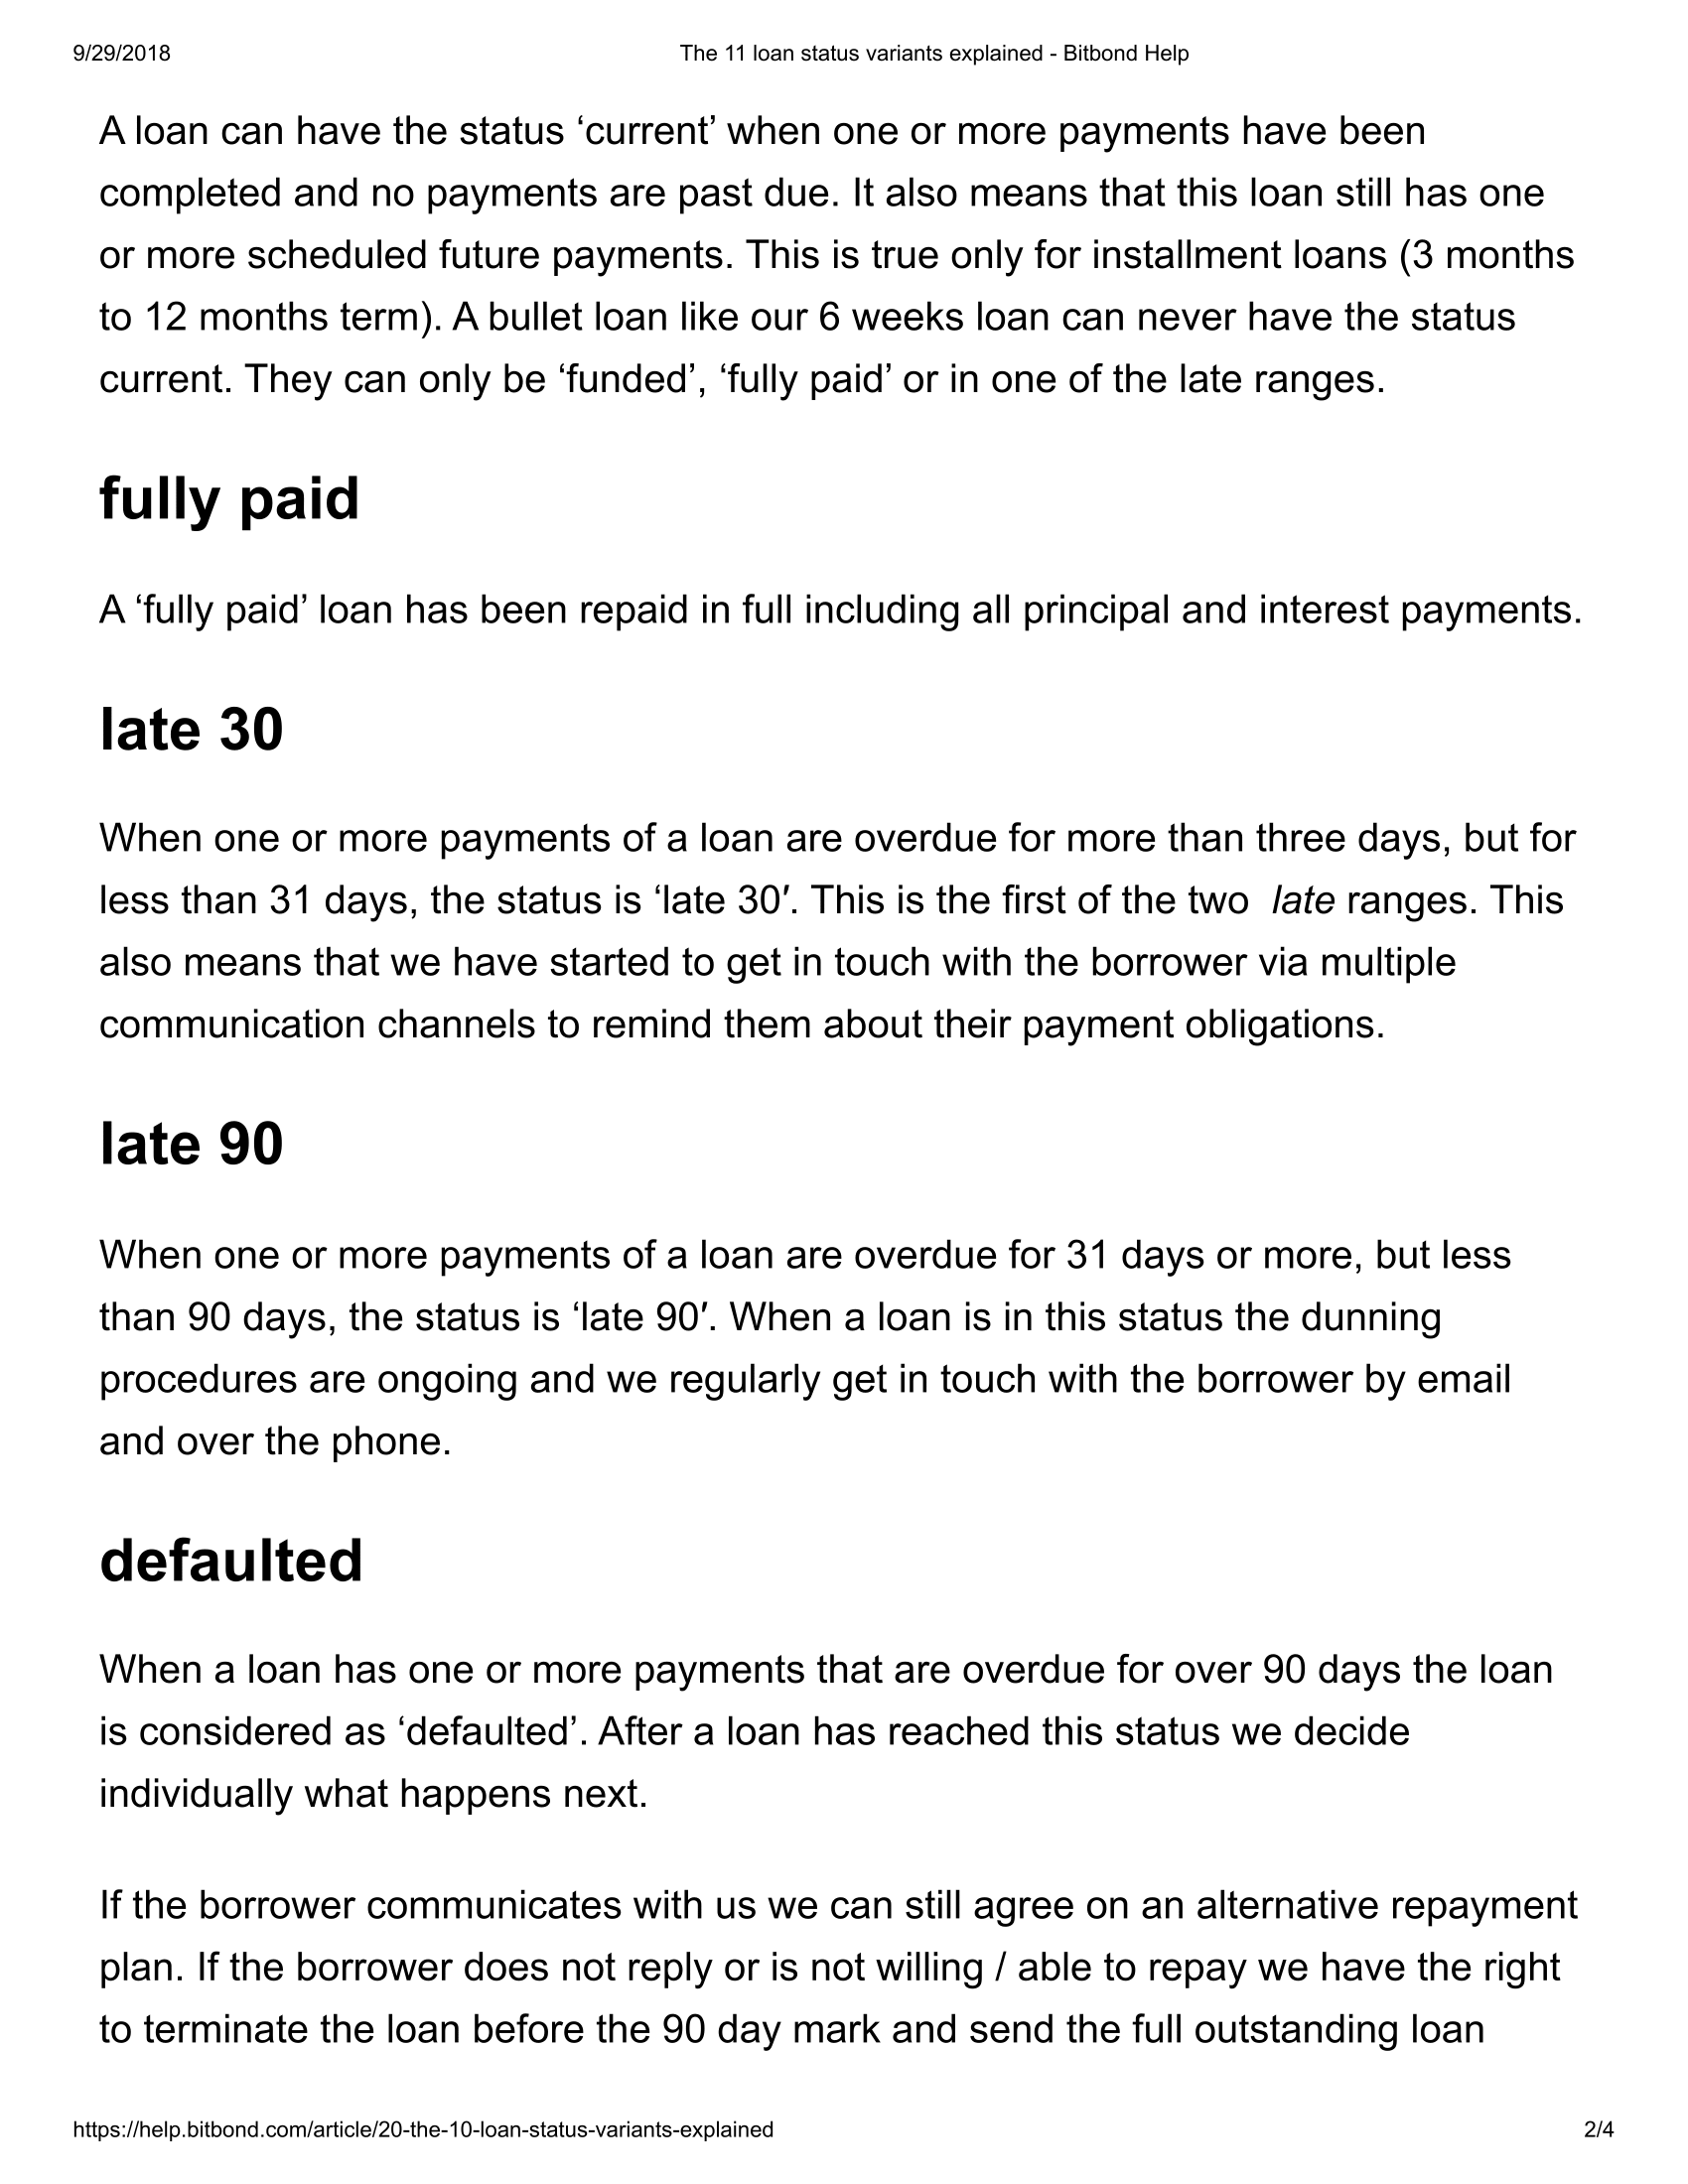

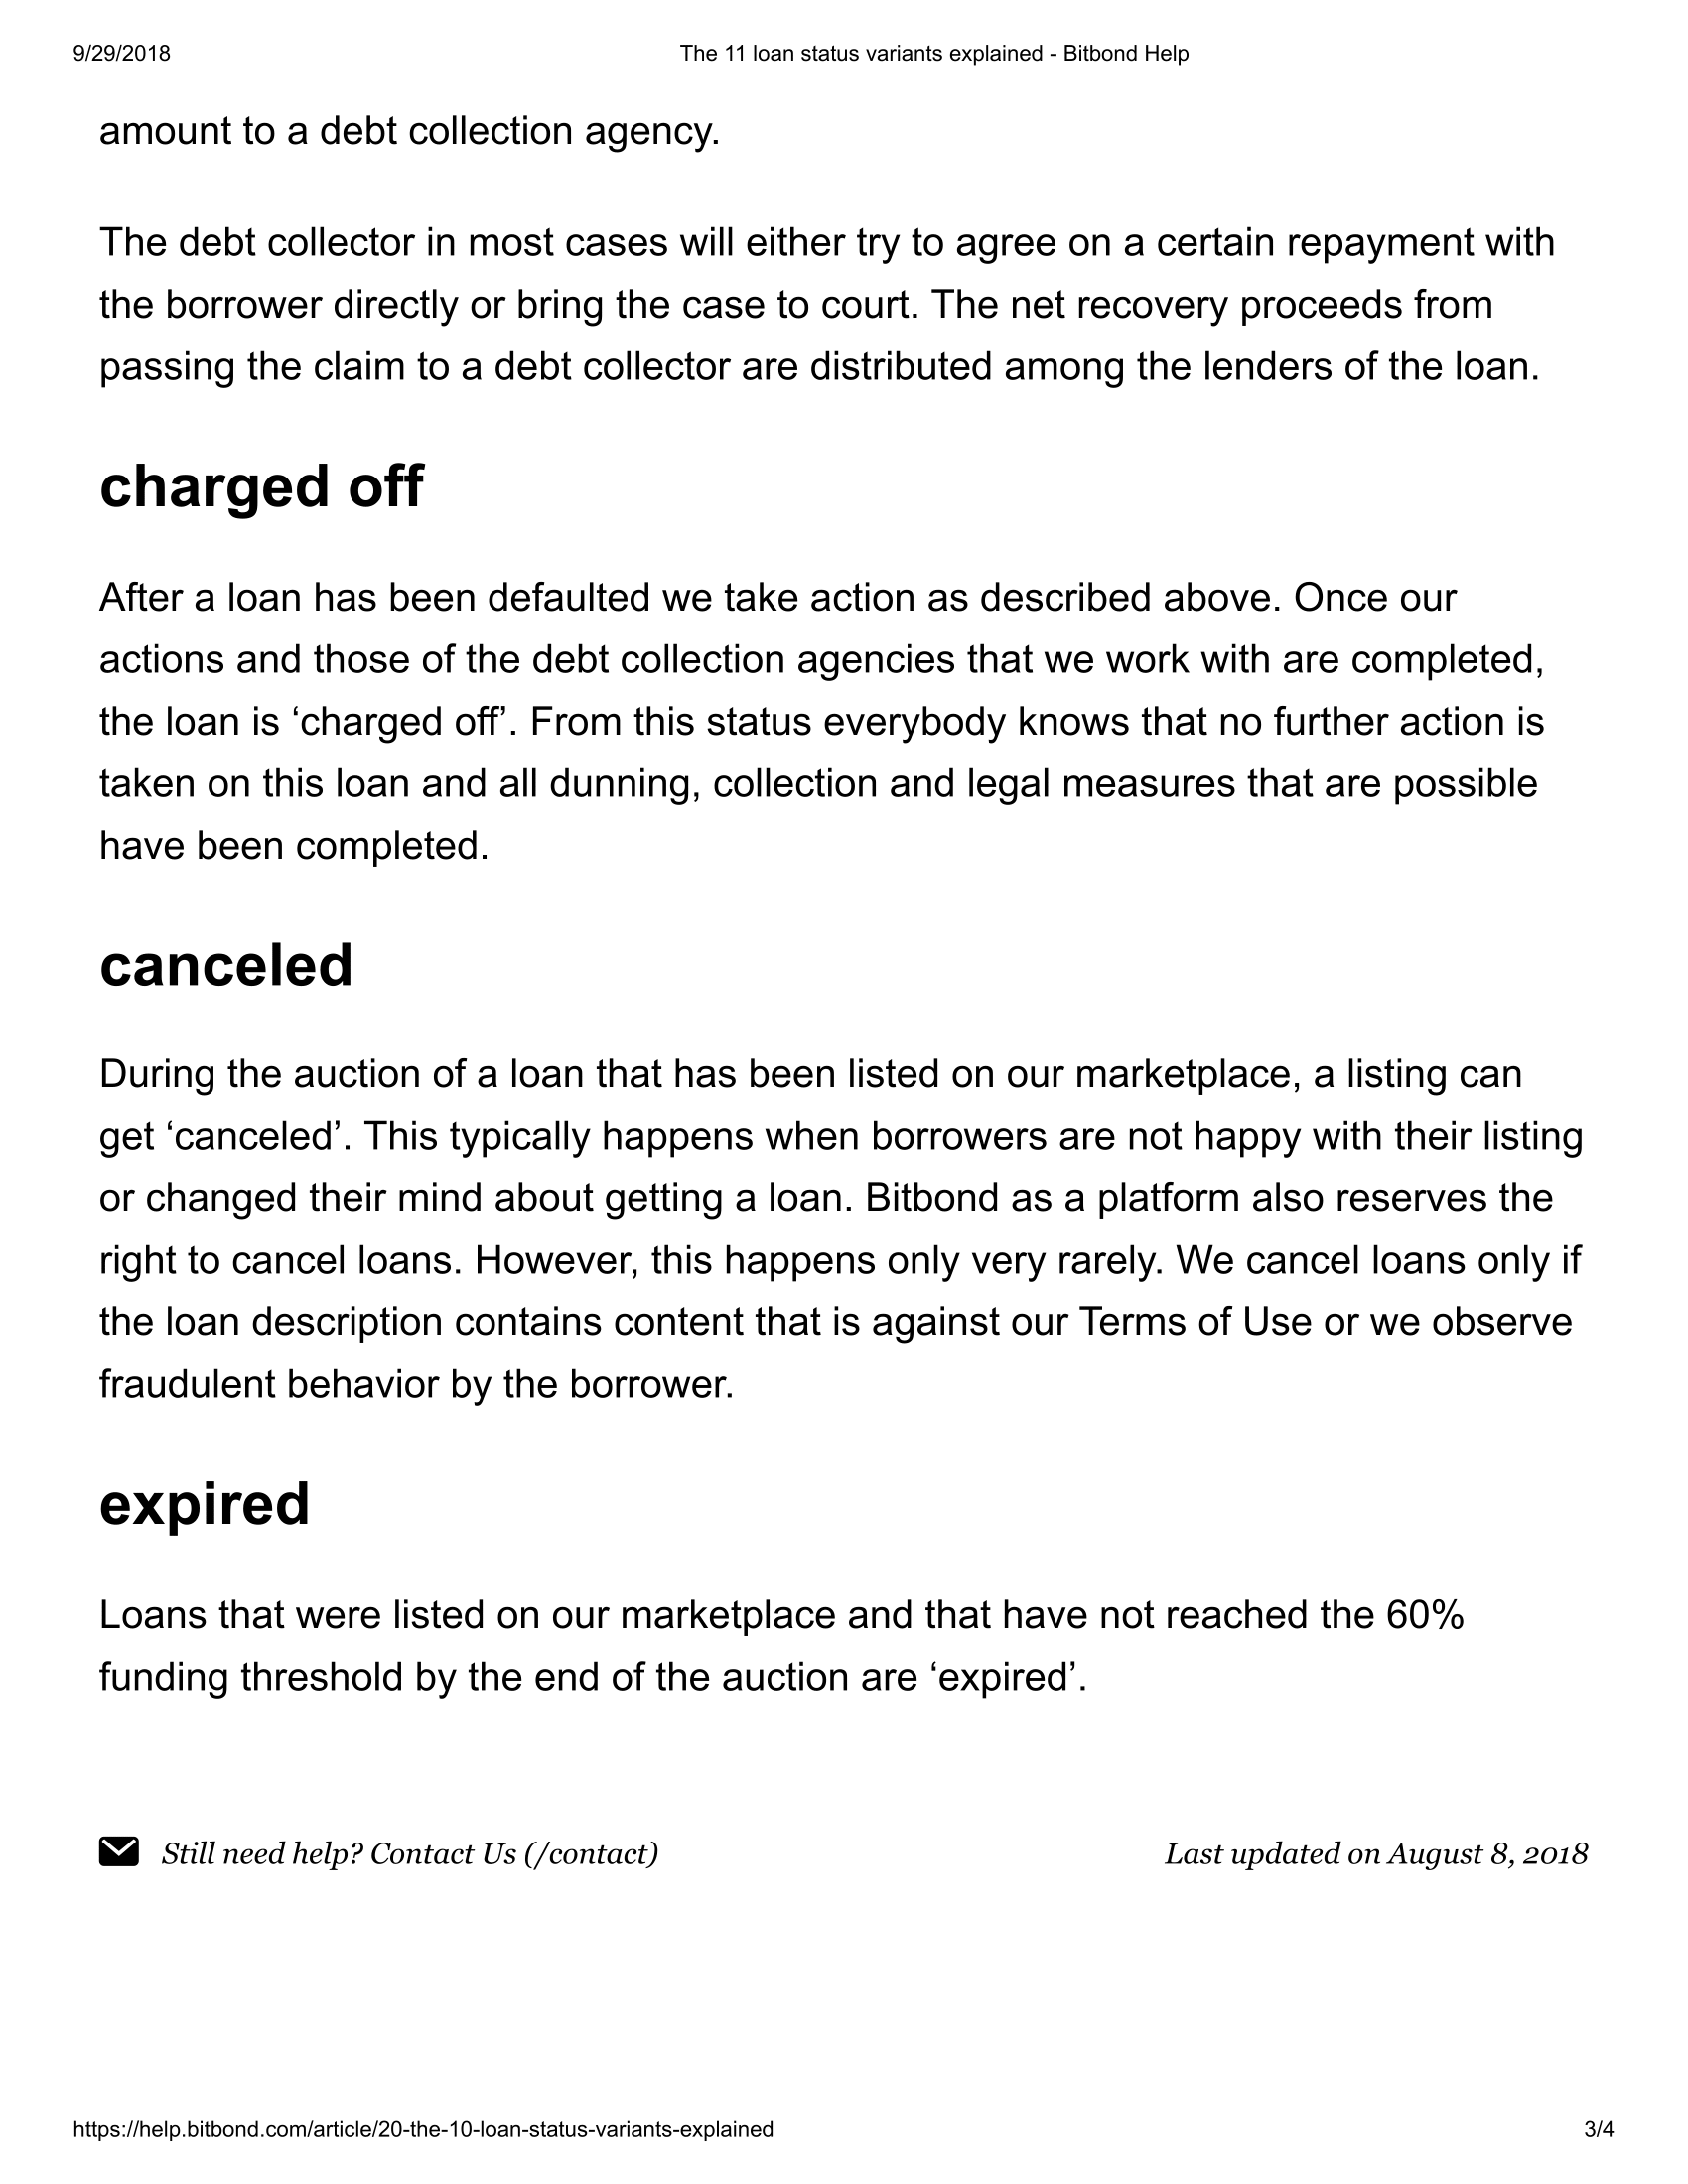

In [658]:
# some background knowledge of loan status
display_png(file="D:/BaiduNetdiskDownload/loan1.png",width = 520, height = 520)
display_png(file="D:/BaiduNetdiskDownload/loan2.png",width = 520, height = 520)
display_png(file="D:/BaiduNetdiskDownload/loan3.png",width = 520, height = 520)

In [659]:
print.data.frame(summary(loan_data$loan_status))
summary(loan_data$loan_status)
nrow(loan_data)

 [1] Charged Off                                        
 [2] Current                                            
 [3] Default                                            
 [4] Does not meet the credit policy. Status:Charged Off
 [5] Does not meet the credit policy. Status:Fully Paid 
 [6] Fully Paid                                         
 [7] In Grace Period                                    
 [8] Issued                                             
 [9] Late (16-30 days)                                  
[10] Late (31-120 days)                                 
<0 rows> (or 0-length row.names)


Charged Off 
                                              44723 
                                            Current 
                                             601047 
                                            Default 
                                               1217 
Does not meet the credit policy. Status:Charged Off 
                                                709 
 Does not meet the credit policy. Status:Fully Paid 
                                               1874 
                                         Fully Paid 
                                             205626 
                                    In Grace Period 
                                               6249 
                                             Issued 
                                               8453 
                                  Late (16-30 days) 
                                               2351 
                                 Late (31-120 days) 
                                              11566

[1] 883815

In [660]:
# further delete the 'Does not meet the credit policy' rows
sql1<-subset(loan_data,loan_status!='Does not meet the credit policy. Status:Fully Paid')

In [661]:
loan_data<-subset(sql1,loan_status!='Does not meet the credit policy. Status:Charged Off')

#### In the following section, I will collapse some levels in loan_status
The mere judgement is whether default happened or not; 

For issued,current, grace day and fully paid, they are indicating a status that the loan and borrower are in healthy condition; Whereas, the late(16+,30+),default and charged off indicating a status of default, post-default and to great possibility default.

In [662]:
sql2<-subset(loan_data,loan_status %in% c('Default','Charged Off','Late (16-30 days)','Late (31-120 days)'))
#http://www.sthda.com/english/wiki/subsetting-data-frame-rows-in-r
nrow(sql2)

[1] 59857

In [663]:
sql2$loan_status<-1

In [664]:
sql3<-subset(loan_data,loan_status %in% c('Current','Fully Paid','In Grace Period','Issued'))
#http://www.sthda.com/english/wiki/subsetting-data-frame-rows-in-r
nrow(sql3)

[1] 821375

In [665]:
sql3$loan_status<-0

In [666]:
loan_data<-rbind(sql2,sql3)

In [667]:
print.data.frame(head(loan_data,5))
nrow(loan_data)

   loan_status      id member_id loan_amnt       term int_rate installment
15           1 1069057   1303503     10000  36 months    10.65      325.74
25           1 1069559   1304634      6000  36 months    11.71      198.46
27           1 1069800   1304679     15000  36 months    14.27      514.64
28           1 1069657   1304764      5000  60 months    16.77      123.65
47           1 1069465   1304521      5000  36 months     8.90      158.77
   grade sub_grade emp_length home_ownership annual_inc verification_status
15     B        B2    3 years           RENT     100000     Source Verified
25     B        B3     1 year           RENT      76000        Not Verified
27     C        C2    9 years           RENT      60000        Not Verified
28     D        D2    2 years           RENT      50004        Not Verified
47     A        A5  10+ years       MORTGAGE     100000     Source Verified
   zip_code addr_state   dti delinq_2yrs earliest_cr_line inq_last_6mths
15    951xx         C

[1] 881232

In [668]:
summary(loan_data)

  loan_status            id             member_id          loan_amnt    
 Min.   :0.00000   Min.   :   54734   Min.   :   70699   Min.   :  500  
 1st Qu.:0.00000   1st Qu.: 9716528   1st Qu.:11256792   1st Qu.: 8000  
 Median :0.00000   Median :34673332   Median :37346407   Median :13000  
 Mean   :0.06792   Mean   :32667034   Mean   :35218702   Mean   :14762  
 3rd Qu.:0.00000   3rd Qu.:55070611   3rd Qu.:58640974   3rd Qu.:20000  
 Max.   :1.00000   Max.   :68617057   Max.   :73544841   Max.   :35000  
                                                                        
         term           int_rate      installment      grade     
  36 months:616936   Min.   : 5.32   Min.   :  15.69   A:147428  
  60 months:264296   1st Qu.: 9.99   1st Qu.: 261.27   B:253303  
                     Median :12.99   Median : 382.55   C:244558  
                     Mean   :13.24   Mean   : 437.22   D:138328  
                     3rd Qu.:16.20   3rd Qu.: 573.06   E: 69769  
                    

### 2.2 Data Processing--Further checking records collapsing within (Other) category

#### In the summary table, not every situations under each column is listed, I will further check the situations collapsing within (others) category

In [669]:
print.data.frame(summary(loan_data$emp_length))
summary(loan_data$emp_length)
nrow(loan_data)

 [1]  1 year   1 year    10+ years 2 years   3 years   4 years   5 years  
 [8] 6 years   7 years   8 years   9 years   n/a      
<0 rows> (or 0-length row.names)


1 year    1 year 10+ years   2 years   3 years   4 years   5 years   6 years 
    69788     56485    290130     78234     69461     52078     55275     42598 
  7 years   8 years   9 years       n/a 
    44334     43694     34467     44688

[1] 881232

#### Collapse rows ' 1 year' and rows '1 year', and then write off rows with n/a  under 'emp_length' 

In [670]:
grep('emp_length',colnames(loan_data))

[1] 10

In [671]:
loan_data[loan_data$emp_length==' 1 year',10]<-'1 year'

In [672]:
loan_data<-loan_data[loan_data$emp_length!="n/a",]

In [673]:
print.data.frame(summary(loan_data$sub_grade))
summary(loan_data$sub_grade)
nrow(loan_data)

 [1] A1 A2 A3 A4 A5 B1 B2 B3 B4 B5 C1 C2 C3 C4 C5 D1 D2 D3 D4 D5 E1 E2 E3 E4 E5
[26] F1 F2 F3 F4 F5 G1 G2 G3 G4 G5
<0 rows> (or 0-length row.names)


A1    A2    A3    A4    A5    B1    B2    B3    B4    B5    C1    C2    C3 
21683 21323 22246 32620 42631 42609 46123 53307 52607 45956 50333 49309 47350 
   C4    C5    D1    D2    D3    D4    D5    E1    E2    E3    E4    E5    F1 
46103 38816 33991 27927 24723 23963 19978 17137 15975 13237 11032  8965  6742 
   F2    F3    F4    F5    G1    G2    G3    G4    G5 
 5048  4162  3185  2434  1739  1300   904   594   492

[1] 836544

In [674]:
print.data.frame(summary(loan_data$home_ownership))
summary(loan_data$home_ownership)

[1] ANY      MORTGAGE NONE     OTHER    OWN      RENT    
<0 rows> (or 0-length row.names)


ANY MORTGAGE     NONE    OTHER      OWN     RENT 
       3   419849       44      130    78450   338068

#### Write off the records with ANY under 'home_ownership'

In [675]:
loan_data<-loan_data[loan_data$home_ownership!="ANY",]
nrow(loan_data)

[1] 836541

### 2.2 Data Processing--Convert timestamp to timespan

#### When looking at 'earliest_cr_line', it is the first date that one borrower got his credit record; the timestamp has few meaning in the model, whereas how long does one borrower have credit history makes some sense

In [676]:
print.data.frame(summary(loan_data$earliest_cr_line))
summary(loan_data$earliest_cr_line)

  [1] 1-Aug   Aug-00  Oct-00  1-Oct   2-Aug   Sep-00  Nov-99  2-Sep   Oct-99 
 [10] Nov-00  1-Sep   2-Oct   3-Sep   Aug-99  Sep-99  1-Jul   3-Aug   3-Oct  
 [19] 1-Nov   1-Mar   Sep-98  4-Sep   Dec-00  1-May   1-Dec   Jul-00  Dec-99 
 [28] Oct-98  Mar-00  1-Jun   2-Jul   May-00  Jun-00  1-Jan   3-Jul   1-Apr  
 [37] 4-Aug   Nov-98  Dec-98  Aug-98  Feb-00  2-May   4-Oct   2-Nov   Jan-00 
 [46] Jul-99  2-Jan   Mar-99  3-May   2-Mar   Oct-97  1-Feb   3-Nov   2-Apr  
 [55] 2-Feb   2-Dec   Apr-00  5-Sep   2-Jun   Jun-99  May-99  Sep-97  3-Mar  
 [64] Oct-95  Oct-96  4-Jul   Nov-97  Sep-95  4-Mar   3-Apr   5-Aug   3-Jun  
 [73] 4-Nov   Apr-99  Dec-97  Nov-96  Feb-99  3-Jan   6-Aug   3-Dec   Jan-99 
 [82] Nov-95  Sep-96  Jul-98  4-May   4-Jun   Aug-97  Aug-96  Jun-98  4-Dec  
 [91] 4-Apr   3-Feb   5-Oct   4-Feb   May-98  Aug-95  Dec-96  Mar-98  Oct-94 
[100] (Other)
<0 rows> (or 0-length row.names)


1-Aug  Aug-00  Oct-00   1-Oct   2-Aug  Sep-00  Nov-99   2-Sep  Oct-99  Nov-00 
   6405    6290    6046    5920    5909    5676    5609    5603    5568    5563 
  1-Sep   2-Oct   3-Sep  Aug-99  Sep-99   1-Jul   3-Aug   3-Oct   1-Nov   1-Mar 
   5456    5447    5435    5361    5354    5109    5039    5022    4991    4953 
 Sep-98   4-Sep  Dec-00   1-May   1-Dec  Jul-00  Dec-99  Oct-98  Mar-00   1-Jun 
   4923    4917    4852    4838    4827    4781    4763    4721    4695    4690 
  2-Jul  May-00  Jun-00   1-Jan   3-Jul   1-Apr   4-Aug  Nov-98  Dec-98  Aug-98 
   4688    4620    4590    4565    4552    4523    4505    4488    4463    4414 
 Feb-00   2-May   4-Oct   2-Nov  Jan-00  Jul-99   2-Jan  Mar-99   3-May   2-Mar 
   4377    4371    4352    4336    4281    4269    4241    4233    4226    4203 
 Oct-97   1-Feb   3-Nov   2-Apr   2-Feb   2-Dec  Apr-00   5-Sep   2-Jun  Jun-99 
   4203    4193    4166    4163    4101    4086    4076    3997    3963    3944 
 May-99  Sep-97   3-Mar  Oct-95  Oct-96   4-Jul  Nov-97  Sep-95   4-Mar   3-Apr 
   3926    3919    3912    3870    3851    3830    3829    3812    3791    3784 
  5-Aug   3-Jun   4-Nov  Apr-99  Dec-97  Nov-96  Feb-99   3-Jan   6-Aug   3-Dec 
   3768    3766    3766    3748    3734    3733    3732    3726    3688    3671 
 Jan-99  Nov-95  Sep-96  Jul-98   4-May   4-Jun  Aug-97  Aug-96  Jun-98   4-Dec 
   3574    3568    3564    3561    3555    3520    3470    3462    3433    3392 
  4-Apr   3-Feb   5-Oct   4-Feb  May-98  Aug-95  Dec-96  Mar-98  Oct-94 (Other) 
   3387    3375    3370    3355    3341    3282    3243    3223    3220  407838

In [677]:
loan_data$earliest_cr_line <-as.character(loan_data$earliest_cr_line)
#convert the factor var to char variable

In [678]:
str(loan_data$earliest_cr_line)

 chr [1:836541] "May-91" "1-Jun" "3-Oct" "3-Oct" "Jun-95" "Apr-92" "6-Oct" ...


#### Because in the following step I would convert the char to date, I should add day to the timestamp

In [679]:
col.one<-c(rep(1,nrow(loan_data)))
head(col.one,5)

[1] 1 1 1 1 1

In [680]:
loan_data$first_day<-col.one
#adding new col with all 1s

In [681]:
loan_data$earliest_crline_date <- paste(loan_data$earliest_cr_line, loan_data$first_day, sep="-")
#Concatenate two cols

In [682]:
print.data.frame(head(loan_data,5))

   loan_status      id member_id loan_amnt       term int_rate installment
15           1 1069057   1303503     10000  36 months    10.65      325.74
25           1 1069559   1304634      6000  36 months    11.71      198.46
27           1 1069800   1304679     15000  36 months    14.27      514.64
28           1 1069657   1304764      5000  60 months    16.77      123.65
47           1 1069465   1304521      5000  36 months     8.90      158.77
   grade sub_grade emp_length home_ownership annual_inc verification_status
15     B        B2    3 years           RENT     100000     Source Verified
25     B        B3     1 year           RENT      76000        Not Verified
27     C        C2    9 years           RENT      60000        Not Verified
28     D        D2    2 years           RENT      50004        Not Verified
47     A        A5  10+ years       MORTGAGE     100000     Source Verified
   zip_code addr_state   dti delinq_2yrs earliest_cr_line inq_last_6mths
15    951xx         C

In [683]:
str(loan_data$earliest_crline_date)

 chr [1:836541] "May-91-1" "1-Jun-1" "3-Oct-1" "3-Oct-1" "Jun-95-1" ...


In [684]:
loan_data[c('first_day','earliest_cr_line')]<-list(NULL)

#### By checking the cols, I realized that part of rows are written in format that starting with year, remaining are starting with months; So I split the dataset into two parts, and then reorder the part beginning with months

In [685]:
month.abb[c(1:12)] #generating 12 months abbrev

[1] "Jan" "Feb" "Mar" "Apr" "May" "Jun" "Jul" "Aug" "Sep" "Oct" "Nov" "Dec"

In [686]:
toMatch <- c(month.abb[c(1:12)])
paste(toMatch,collapse="|^")
toNum<- c(1:10)
paste(toNum,collapse="|^")

[1] "Jan|^Feb|^Mar|^Apr|^May|^Jun|^Jul|^Aug|^Sep|^Oct|^Nov|^Dec"

[1] "1|^2|^3|^4|^5|^6|^7|^8|^9|^10"

In [687]:
e<-grep('^Jan|^Feb|^Mar|^Apr|^May|^Jun|^Jul|^Aug|^Sep|^Oct|^Nov|^Dec',loan_data$earliest_crline_date)
length(e)
f<-grep('^1|^2|^3|^4|^5|^6|^7|^8|^9|^10',loan_data$earliest_crline_date)
length(f)
all.equal(length(e)+length(f),nrow(loan_data))

[1] 490341

[1] 346200

[1] TRUE

In [688]:
sqlf<-loan_data[f,]
head(sqlf,5)

,loan_status,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,...,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,earliest_crline_date
25,1,1069559,1304634,6000,36 months,11.71,198.46,B,B3,1 year,...,2.40,0,1,7,5963,29.7,7,f,0,1-Jun-1
27,1,1069800,1304679,15000,36 months,14.27,514.64,C,C2,9 years,...,15.22,0,1,7,5872,57.6,11,f,0,3-Oct-1
28,1,1069657,1304764,5000,60 months,16.77,123.65,D,D2,2 years,...,13.97,3,0,14,4345,59.5,22,f,0,3-Oct-1
54,1,1069243,1304116,12000,36 months,15.96,421.65,C,C5,4 years,...,20.88,0,2,11,15793,90.8,11,f,0,6-Oct-1
146,1,1068091,1302450,12000,36 months,9.91,386.70,B,B1,2 years,...,7.83,0,2,8,9749,65.4,16,f,0,6-Jun-1


In [689]:
sqle<-loan_data[e,]
head(sqle,5)

,loan_status,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,...,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,earliest_crline_date
15,1,1069057,1303503,10000,36 months,10.65,325.74,B,B2,3 years,...,7.06,0,2,14,11997,55.5,29,f,0,May-91-1
47,1,1069465,1304521,5000,36 months,8.90,158.77,A,A5,10+ years,...,16.33,0,0,17,74351,62.1,35,f,0,Jun-95-1
51,1,1069248,1304123,15000,36 months,9.91,483.38,B,B1,8 years,...,9.12,0,2,9,11845,63.7,28,f,0,Apr-92-1
56,1,1069410,1303652,21000,60 months,19.91,555.33,E,E4,7 years,...,21.58,0,1,7,19448,97.6,14,f,0,Sep-98-1
65,1,1069126,1303778,10000,60 months,10.65,215.69,B,B2,10+ years,...,21.73,0,1,7,11170,30.1,15,f,0,May-97-1


In [690]:
sqle<-sqle %>% separate(earliest_crline_date, c("mon", "yr",'day'), "-")

In [691]:
head(sqle,5)

,loan_status,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,...,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,mon,yr,day
15,1,1069057,1303503,10000,36 months,10.65,325.74,B,B2,3 years,...,2,14,11997,55.5,29,f,0,May,91,1
47,1,1069465,1304521,5000,36 months,8.90,158.77,A,A5,10+ years,...,0,17,74351,62.1,35,f,0,Jun,95,1
51,1,1069248,1304123,15000,36 months,9.91,483.38,B,B1,8 years,...,2,9,11845,63.7,28,f,0,Apr,92,1
56,1,1069410,1303652,21000,60 months,19.91,555.33,E,E4,7 years,...,1,7,19448,97.6,14,f,0,Sep,98,1
65,1,1069126,1303778,10000,60 months,10.65,215.69,B,B2,10+ years,...,1,7,11170,30.1,15,f,0,May,97,1


In [692]:
sqle$earliest_crline_date <- paste(sqle$yr, sqle$mon,sqle$day, sep="-")
# reorder several splitted cols to construct the Concatenated col

In [693]:
sqle[c("yr",'mon','day')]<-list(NULL)

In [694]:
all.equal(ncol(sqle),ncol(sqlf))
all.equal(colnames(sqle),colnames(sqlf))
loan_data<-rbind(sqle,sqlf)

[1] TRUE

[1] TRUE

In [695]:
class(loan_data$earliest_crline_date)

[1] "character"

#### After several executions, I get the 'earliest_crline_date' in format 'yyyy-mm-dd', and then calculate the timespan

In [696]:
loan_data$earliest_crline_date <-as.Date(chron(dates=loan_data$earliest_crline_date, format = c(dates="y-mon-d")))
class(loan_data$earliest_crline_date)

[1] "Date"

In [697]:
timeSpan <-as.integer(difftime('2018-10-01',loan_data$earliest_crline_date,units='days'))
head(timeSpan,10)
class(timeSpan)
#use difftime function to get the time invertal between the borrow's first credit record date and current date

[1] 10015  8523  9679  7335  7823  7884  8523  7093  6879 10166

[1] "integer"

In [698]:
loan_data$days_from_crline<-timeSpan

In [699]:
loan_data$earliest_crline_date<-NULL

### 3.1 Data Processing--Detect outliners within continuous variables

#### First look at the class of each columan, and further check continuous vars

In [700]:
str(loan_data)
# the numeric/interger cols need further check

'data.frame':	836541 obs. of  25 variables:
 $ loan_status        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ id                 : int  1069057 1069465 1069248 1069410 1069126 1068012 1066215 1067818 1067364 1067126 ...
 $ member_id          : int  1303503 1304521 1304123 1303652 1303778 1302365 1300572 1247741 1301744 1301506 ...
 $ loan_amnt          : int  10000 5000 15000 21000 10000 10000 24000 5600 10000 21000 ...
 $ term               : Factor w/ 2 levels " 36 months"," 60 months": 1 1 1 2 2 1 1 1 1 2 ...
 $ int_rate           : num  10.65 8.9 9.91 19.91 10.65 ...
 $ installment        : num  326 159 483 555 216 ...
 $ grade              : Factor w/ 7 levels "A","B","C","D",..: 2 1 2 5 2 4 3 3 3 2 ...
 $ sub_grade          : Factor w/ 35 levels "A1","A2","A3",..: 7 5 6 24 7 20 15 13 11 8 ...
 $ emp_length         : Factor w/ 12 levels " 1 year","1 year",..: 5 3 10 9 3 2 10 2 7 5 ...
 $ home_ownership     : Factor w/ 6 levels "ANY","MORTGAGE",..: 6 2 2 6 6 6 2 2 6 6 ...
 $ annual_inc      

In [701]:
summary(loan_data$loan_amnt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    500    8400   13225   14922   20000   35000 

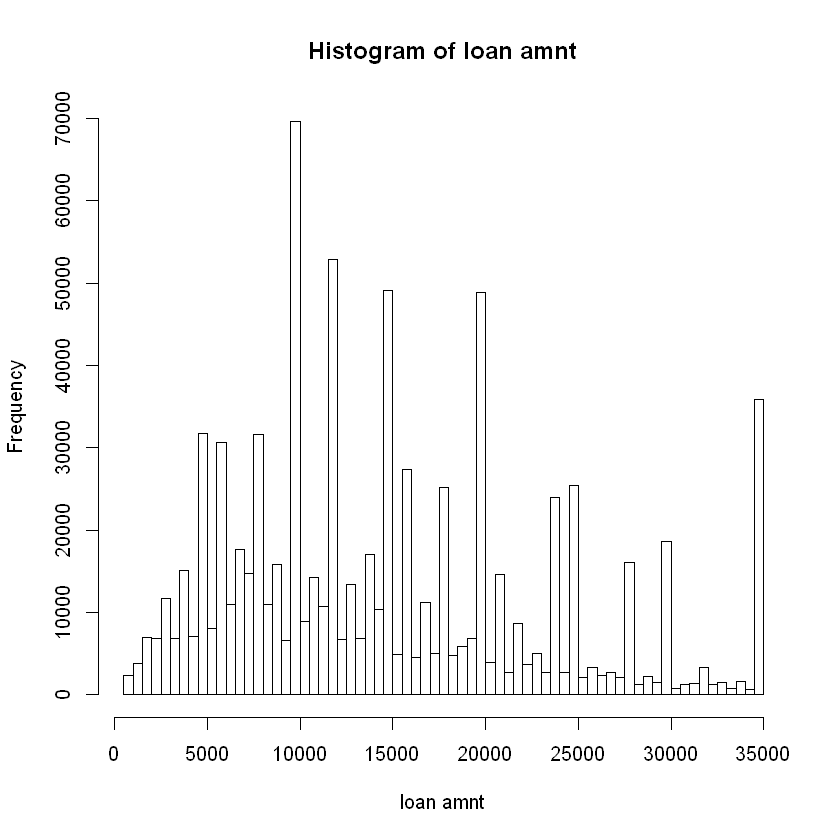

In [702]:
#n_breaks=sqrt(nrow(loan_data))
hist(loan_data$loan_amnt,breaks=100,xlab='loan amnt',main='Histogram of loan amnt')

#### Detect the outliners within annual_income, and delete rows with outliners (if bigger than Q3+ 1.5*IQR)

In [703]:
summary(loan_data$annual_inc);nrow(loan_data);ncol(loan_data)
#found the max of annual income is way more than the mean

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3800   47000   65000   76350   90000 9500000 

[1] 836541

[1] 25

In [704]:
loan_out<-loan_data

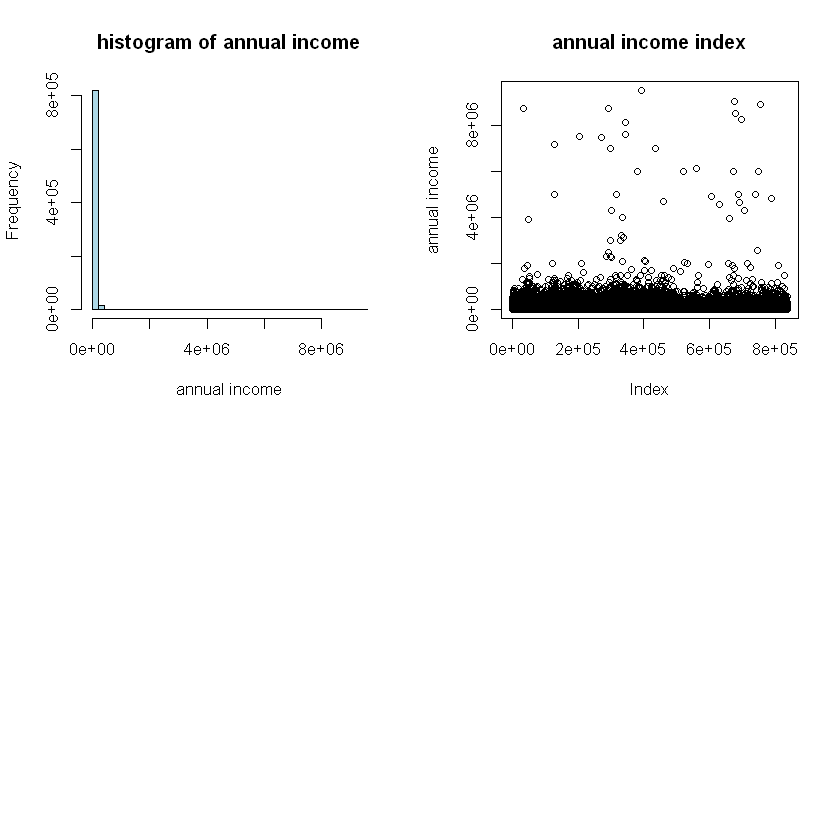

In [705]:
layout(matrix(c(1,2,
               3,4), nrow = 2, ncol=2,byrow = TRUE))
#layout.show(n=4)
hist(loan_out$annual_inc,breaks=50,freq=TRUE,xlab='annual income',main='histogram of annual income',col='lightblue')
plot(loan_out$annual_inc,ylab='annual income',main='annual income index')

In [706]:
outlier_cutoff <- quantile(loan_data$annual_inc, 0.75) + 1.5 * IQR(loan_data$annual_inc)
outlier_cutoff

75% 
154500

In [707]:
loan_data<-subset(loan_data,loan_data$annual_inc<outlier_cutoff,select=1:25)

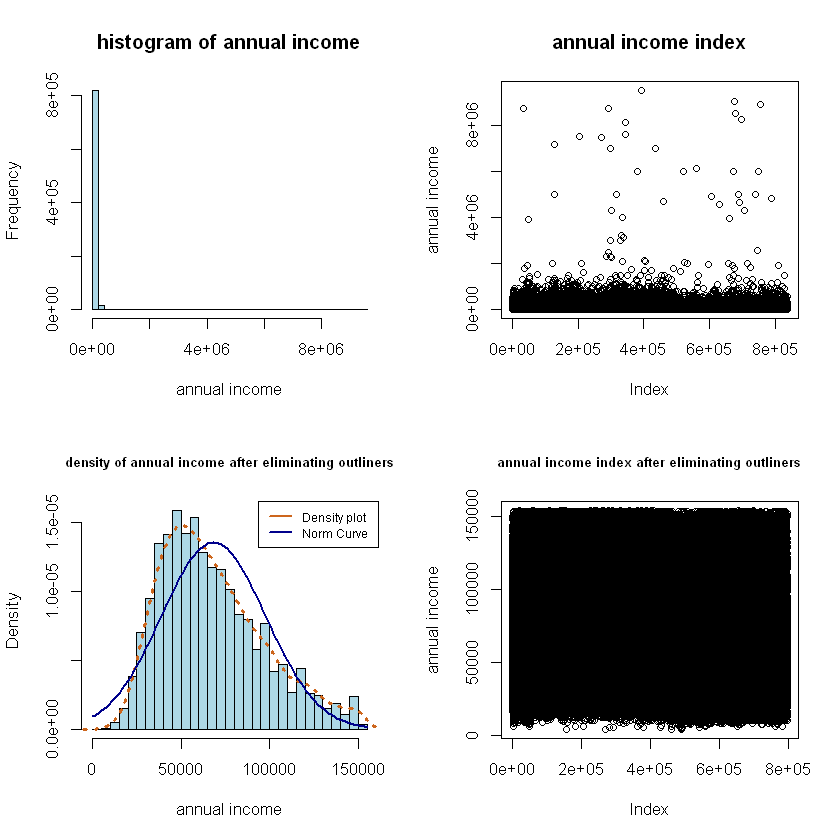

In [708]:
layout(matrix(c(1,2,
               3,4), nrow = 2, ncol=2,byrow = TRUE))
#layout.show(n=4)
hist(loan_out$annual_inc,breaks=50,freq=TRUE,xlab='annual income',main='histogram of annual income',col='lightblue')
plot(loan_out$annual_inc,ylab='annual income',main='annual income index')
hist(loan_data$annual_inc,breaks=50,freq=FALSE,xlab='annual income',main='density of annual income after eliminating outliners',
     cex.main=0.8,col='lightblue')
lines(density(loan_data$annual_inc,adjust=3),lty='dotted',lwd = 3,col = "chocolate3")
curve(dnorm(x, mean=mean(loan_data$annual_inc), sd=sd(loan_data$annual_inc)), add=TRUE, col='darkblue', lwd=2)
legend(x = "topright", c("Density plot","Norm Curve"),col = c("chocolate3","darkblue"),lwd = c(2, 2),cex=0.7)
plot(loan_data$annual_inc,ylab='annual income',main='annual income index after eliminating outliners',cex.main=0.8)

#https://www.r-bloggers.com/adding-measures-of-central-tendency-to-histograms-in-r/

In [709]:
summary(loan_data$annual_inc)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3800   45000   63000   68342   85000  154452 

#### Further check other continuous vars, using both rule of thumbs, and empirical cdf method to detect the outliners

##### 6 plots summary

In [710]:
colnames(loan_data)

[1] "loan_status"         "id"                  "member_id"          
 [4] "loan_amnt"           "term"                "int_rate"           
 [7] "installment"         "grade"               "sub_grade"          
[10] "emp_length"          "home_ownership"      "annual_inc"         
[13] "verification_status" "zip_code"            "addr_state"         
[16] "dti"                 "delinq_2yrs"         "inq_last_6mths"     
[19] "open_acc"            "revol_bal"           "revol_util"         
[22] "total_acc"           "initial_list_status" "out_prncp"          
[25] "days_from_crline"

In [711]:
summary(loan_data$open_acc);summary(loan_data$total_acc);summary(loan_data$days_from_crline)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    8.00   11.00   11.52   14.00   90.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00   16.00   23.00   25.03   32.00  169.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2160    5540    6879    7343    8705   27302 

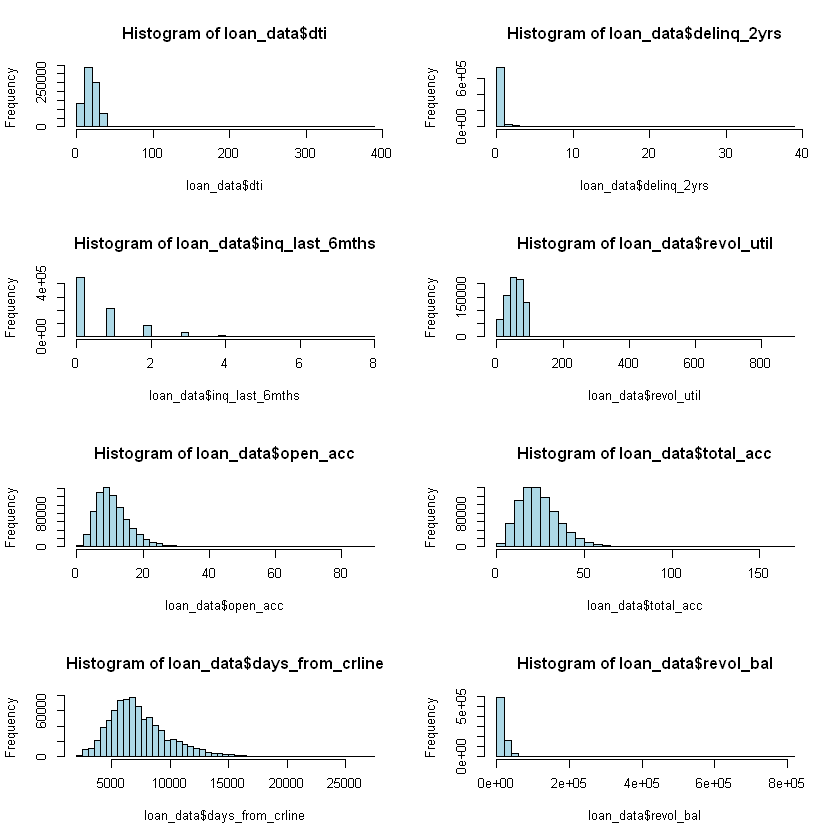

In [712]:
layout(matrix(c(1,2,
               3,4,
               5,6,
               7,8), nrow = 4, ncol=2,byrow = TRUE))
#layout.show(n=4)
hist(loan_data$dti,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$delinq_2yrs,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$inq_last_6mths,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$revol_util,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$open_acc,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$total_acc,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$days_from_crline,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$revol_bal,breaks=50,freq=TRUE,col='lightblue')

##### debt to income ratio

In [713]:
outlier_cutoff_1<- quantile(loan_data$dti, 0.75) + 1.5 * IQR(loan_data$dti)
outlier_cutoff_1;max(loan_data$dti)
loan_data<-subset(loan_data,loan_data$dti<outlier_cutoff_1,select=1:25)
nrow(loan_data)

75% 
41.98

[1] 380.53

[1] 795364

##### delinquent during past 2 yrs

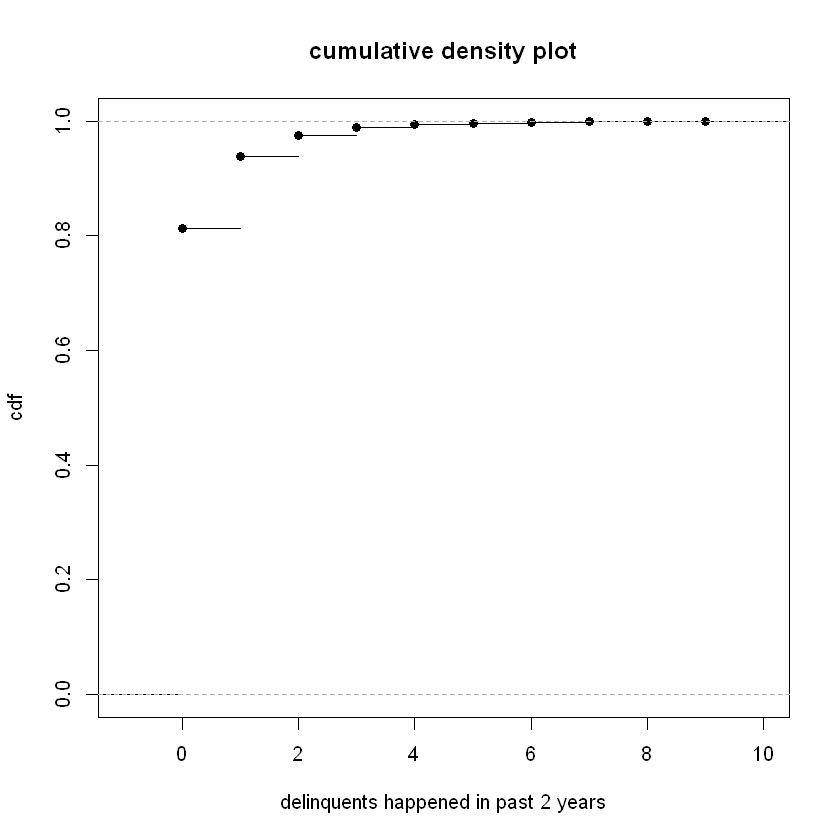

In [729]:
plot(ecdf(loan_data$delinq_2yrs),xlab='delinquents happened in past 2 years',ylab='cdf',
     main='cumulative density plot')
#https://www.r-bloggers.com/basics-of-histograms/
#https://www.statmethods.net/advgraphs/parameters.html
outlier_cutoff_2<-10
nrow(subset(loan_data,loan_data$delinq_2yrs>outlier_cutoff_2,select=1:25))
loan_data<-subset(loan_data,loan_data$delinq_2yrs<outlier_cutoff_2,select=1:25)
nrow(loan_data)

##### revolving balance

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    6412   11666   15727   20077  814300 

97.5% 
50461.22

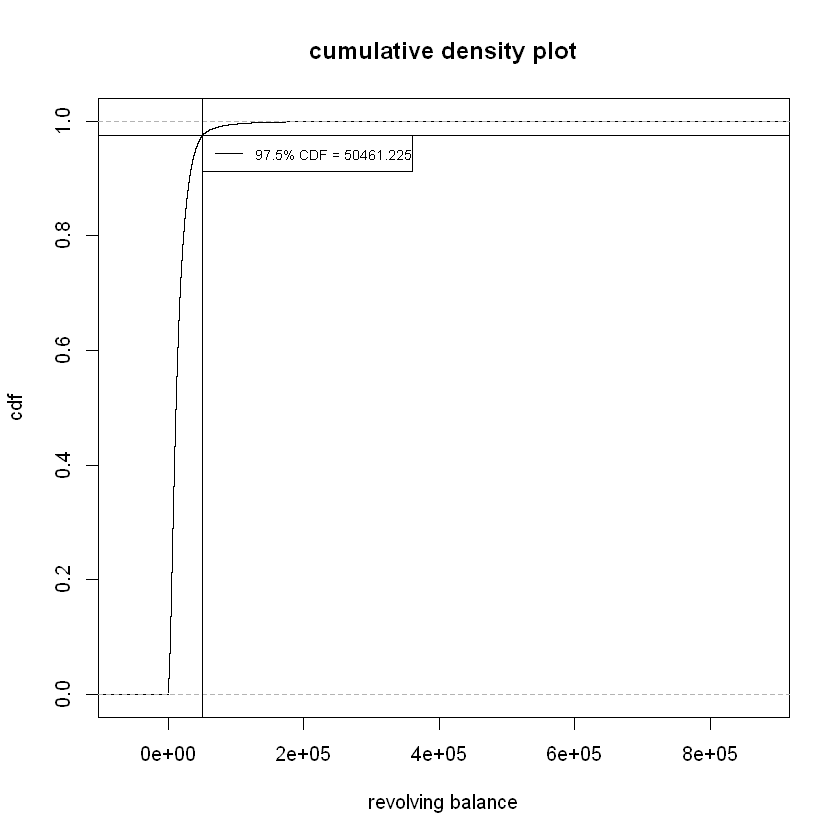

In [715]:
summary(loan_data$revol_bal)
quantile(loan_data$revol_bal, c(.975)) 
plot(ecdf(loan_data$revol_bal),xlab='revolving balance',ylab='cdf',
     main='cumulative density plot')
abline(v= 50461.225,h=0.975)
legend(50461.225, 0.975, '97.5% CDF = 50461.225 ', lwd = 0,cex=0.7)

In [716]:
outlier_cutoff_3<-50461
nrel=nrow(subset(loan_data,loan_data$revol_bal>outlier_cutoff_3,select=1:25))
nrel/nrow(loan_data)
loan_data<-subset(loan_data,loan_data$revol_bal<outlier_cutoff_3,select=1:25)
nrow(loan_data)

[1] 0.02500025

[1] 774959

##### revolving utilization rate

In [736]:
#outlier_cutoff_4<- quantile(loan_data$revol_util, 0.75) + 1.5 * IQR(loan_data$revol_util)
#outlier_cutoff_4;max(loan_data$revol_util)
outlier_cutoff_4<-100
nutl=nrow(subset(loan_data,loan_data$revol_util>outlier_cutoff_4,select=1:25))
nutl/nrow(loan_data)
loan_data<-subset(loan_data,loan_data$revol_util<outlier_cutoff_4,select=1:25)
nrow(loan_data)

[1] 0.003978306

[1] 708328

##### number of open credit lines

In [721]:
outlier_cutoff_5<- quantile(loan_data$open_acc, 0.75) + 1.5 * IQR(loan_data$open_acc)
outlier_cutoff_5;max(loan_data$open_acc)
nop=nrow(subset(loan_data,loan_data$open_acc>outlier_cutoff_5,select=1:25))
nop/nrow(loan_data)
loan_data<-subset(loan_data,loan_data$open_acc<outlier_cutoff_5,select=1:25)
nrow(loan_data)

75% 
 23

[1] 84

[1] 0.02862884

[1] 746754

##### number of total credit lines in borrower's credit history

In [723]:
outlier_cutoff_6<- quantile(loan_data$total_acc, 0.75) + 1.5 * IQR(loan_data$total_acc)
outlier_cutoff_6;max(loan_data$total_acc)
ntl=nrow(subset(loan_data,loan_data$total_acc>outlier_cutoff_6,select=1:25))
ntl/nrow(loan_data)
loan_data<-subset(loan_data,loan_data$total_acc<outlier_cutoff_6,select=1:25)
nrow(loan_data)

75% 
 51

[1] 156

[1] 0.01640299

[1] 732561

##### timespan from the first day of credit record

In [725]:
outlier_cutoff_7<- quantile(loan_data$days_from_crline, 0.75) + 1.5 * IQR(loan_data$days_from_crline)
outlier_cutoff_7;max(loan_data$days_from_crline)
ntp=nrow(subset(loan_data,loan_data$days_from_crline>outlier_cutoff_7,select=1:25))
ntp/nrow(loan_data)
loan_data<-subset(loan_data,loan_data$days_from_crline<outlier_cutoff_7,select=1:25)
nrow(loan_data)

75% 
13121.5

[1] 27302

[1] 0.02894366

[1] 711358

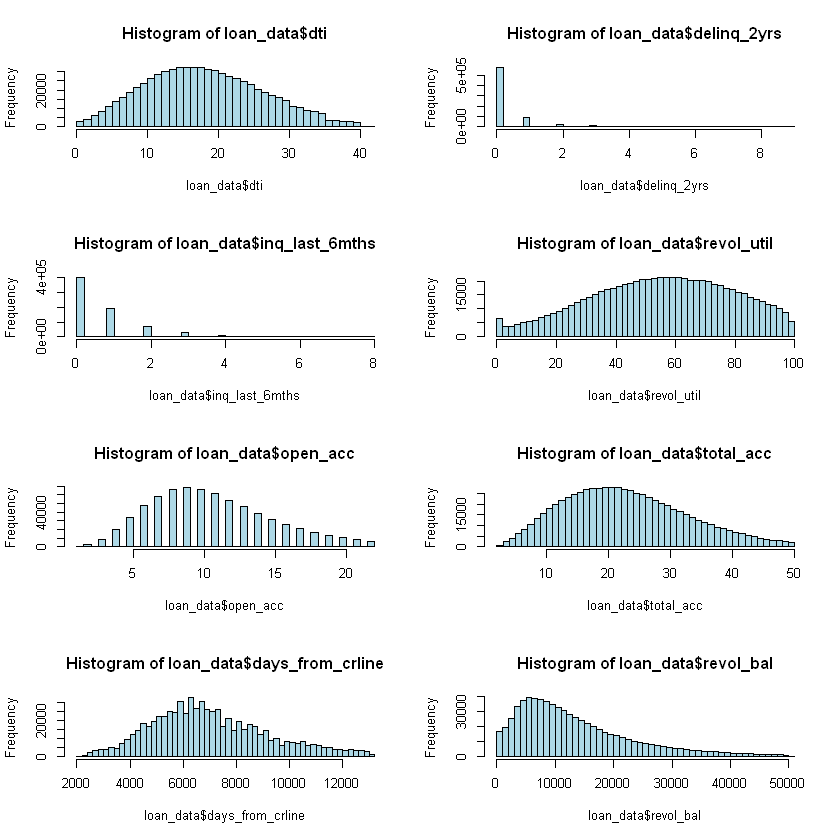

In [738]:
layout(matrix(c(1,2,
               3,4,
               5,6,
               7,8), nrow = 4, ncol=2,byrow = TRUE))
#layout.show(n=4)
hist(loan_data$dti,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$delinq_2yrs,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$inq_last_6mths,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$revol_util,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$open_acc,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$total_acc,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$days_from_crline,breaks=50,freq=TRUE,col='lightblue')
hist(loan_data$revol_bal,breaks=50,freq=TRUE,col='lightblue')

### 3.2 Dummy Coding the categorical variables into multiple cols with 0 or 1

#### State

In [92]:
str(loan_data)

'data.frame':	708328 obs. of  27 variables:
 $ loan_status        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ id                 : int  1069057 1069248 1069410 1069126 1068012 1066215 1067818 1067364 1067126 1067102 ...
 $ member_id          : int  1303503 1304123 1303652 1303778 1302365 1300572 1247741 1301744 1301506 1301481 ...
 $ loan_amnt          : int  10000 15000 21000 10000 10000 24000 5600 10000 21000 15000 ...
 $ term               : Factor w/ 2 levels " 36 months"," 60 months": 1 1 2 2 1 1 1 1 2 1 ...
 $ int_rate           : num  10.65 9.91 19.91 10.65 18.25 ...
 $ installment        : num  326 483 555 216 363 ...
 $ grade              : Factor w/ 7 levels "A","B","C","D",..: 2 2 5 2 4 3 3 3 2 4 ...
 $ sub_grade          : Factor w/ 35 levels "A1","A2","A3",..: 7 6 24 7 20 15 13 11 8 18 ...
 $ emp_length         : Factor w/ 10 levels "1 year","10+ years",..: 4 9 8 2 1 9 1 6 4 9 ...
 $ home_ownership     : Factor w/ 5 levels "MORTGAGE","NONE",..: 5 1 5 5 5 1 1 5 5 5 ...
 $ annual_inc 

In [152]:
levels(loan_data$addr_state)

[1] "AK" "AL" "AR" "AZ" "CA" "CO" "CT" "DC" "DE" "FL" "GA" "HI" "IA" "ID" "IL"
[16] "IN" "KS" "KY" "LA" "MA" "MD" "ME" "MI" "MN" "MO" "MS" "MT" "NC" "ND" "NE"
[31] "NH" "NJ" "NM" "NV" "NY" "OH" "OK" "OR" "PA" "RI" "SC" "SD" "TN" "TX" "UT"
[46] "VA" "VT" "WA" "WI" "WV" "WY"

In [156]:
state<-c(levels(loan_data$addr_state))

In [157]:
state

[1] "AK" "AL" "AR" "AZ" "CA" "CO" "CT" "DC" "DE" "FL" "GA" "HI" "IA" "ID" "IL"
[16] "IN" "KS" "KY" "LA" "MA" "MD" "ME" "MI" "MN" "MO" "MS" "MT" "NC" "ND" "NE"
[31] "NH" "NJ" "NM" "NV" "NY" "OH" "OK" "OR" "PA" "RI" "SC" "SD" "TN" "TX" "UT"
[46] "VA" "VT" "WA" "WI" "WV" "WY"

In [158]:
for (i in 1:length(state)) {
    cat('loan_data$state_',state[i],'<- rep(0,nrow(loan_data))',sep='')
    cat("\n")}

loan_data$state_AK<- rep(0,nrow(loan_data))
loan_data$state_AL<- rep(0,nrow(loan_data))
loan_data$state_AR<- rep(0,nrow(loan_data))
loan_data$state_AZ<- rep(0,nrow(loan_data))
loan_data$state_CA<- rep(0,nrow(loan_data))
loan_data$state_CO<- rep(0,nrow(loan_data))
loan_data$state_CT<- rep(0,nrow(loan_data))
loan_data$state_DC<- rep(0,nrow(loan_data))
loan_data$state_DE<- rep(0,nrow(loan_data))
loan_data$state_FL<- rep(0,nrow(loan_data))
loan_data$state_GA<- rep(0,nrow(loan_data))
loan_data$state_HI<- rep(0,nrow(loan_data))
loan_data$state_IA<- rep(0,nrow(loan_data))
loan_data$state_ID<- rep(0,nrow(loan_data))
loan_data$state_IL<- rep(0,nrow(loan_data))
loan_data$state_IN<- rep(0,nrow(loan_data))
loan_data$state_KS<- rep(0,nrow(loan_data))
loan_data$state_KY<- rep(0,nrow(loan_data))
loan_data$state_LA<- rep(0,nrow(loan_data))
loan_data$state_MA<- rep(0,nrow(loan_data))
loan_data$state_MD<- rep(0,nrow(loan_data))
loan_data$state_ME<- rep(0,nrow(loan_data))
loan_data$state_MI<- rep(0,nrow(

In [161]:
loan_data$state_AK<- rep(0,nrow(loan_data))
loan_data$state_AL<- rep(0,nrow(loan_data))
loan_data$state_AR<- rep(0,nrow(loan_data))
loan_data$state_AZ<- rep(0,nrow(loan_data))
loan_data$state_CA<- rep(0,nrow(loan_data))
loan_data$state_CO<- rep(0,nrow(loan_data))
loan_data$state_CT<- rep(0,nrow(loan_data))
loan_data$state_DC<- rep(0,nrow(loan_data))
loan_data$state_DE<- rep(0,nrow(loan_data))
loan_data$state_FL<- rep(0,nrow(loan_data))
loan_data$state_GA<- rep(0,nrow(loan_data))
loan_data$state_HI<- rep(0,nrow(loan_data))
loan_data$state_IA<- rep(0,nrow(loan_data))
loan_data$state_ID<- rep(0,nrow(loan_data))
loan_data$state_IL<- rep(0,nrow(loan_data))
loan_data$state_IN<- rep(0,nrow(loan_data))
loan_data$state_KS<- rep(0,nrow(loan_data))
loan_data$state_KY<- rep(0,nrow(loan_data))
loan_data$state_LA<- rep(0,nrow(loan_data))
loan_data$state_MA<- rep(0,nrow(loan_data))
loan_data$state_MD<- rep(0,nrow(loan_data))
loan_data$state_ME<- rep(0,nrow(loan_data))
loan_data$state_MI<- rep(0,nrow(loan_data))
loan_data$state_MN<- rep(0,nrow(loan_data))
loan_data$state_MO<- rep(0,nrow(loan_data))
loan_data$state_MS<- rep(0,nrow(loan_data))
loan_data$state_MT<- rep(0,nrow(loan_data))
loan_data$state_NC<- rep(0,nrow(loan_data))
loan_data$state_ND<- rep(0,nrow(loan_data))
loan_data$state_NE<- rep(0,nrow(loan_data))
loan_data$state_NH<- rep(0,nrow(loan_data))
loan_data$state_NJ<- rep(0,nrow(loan_data))
loan_data$state_NM<- rep(0,nrow(loan_data))
loan_data$state_NV<- rep(0,nrow(loan_data))
loan_data$state_NY<- rep(0,nrow(loan_data))
loan_data$state_OH<- rep(0,nrow(loan_data))
loan_data$state_OK<- rep(0,nrow(loan_data))
loan_data$state_OR<- rep(0,nrow(loan_data))
loan_data$state_PA<- rep(0,nrow(loan_data))
loan_data$state_RI<- rep(0,nrow(loan_data))
loan_data$state_SC<- rep(0,nrow(loan_data))
loan_data$state_SD<- rep(0,nrow(loan_data))
loan_data$state_TN<- rep(0,nrow(loan_data))
loan_data$state_TX<- rep(0,nrow(loan_data))
loan_data$state_UT<- rep(0,nrow(loan_data))
loan_data$state_VA<- rep(0,nrow(loan_data))
loan_data$state_VT<- rep(0,nrow(loan_data))
loan_data$state_WA<- rep(0,nrow(loan_data))
loan_data$state_WI<- rep(0,nrow(loan_data))
loan_data$state_WV<- rep(0,nrow(loan_data))
loan_data$state_WY<- rep(0,nrow(loan_data))

In [168]:
for (i in 1:length(state)) {
    cat('loan_data$state_',state[i],"[loan_data$addr_state=='",state[i],"']<-1",sep='')
    cat("\n")}

loan_data$state_AK[loan_data$addr_state=='AK']<-1
loan_data$state_AL[loan_data$addr_state=='AL']<-1
loan_data$state_AR[loan_data$addr_state=='AR']<-1
loan_data$state_AZ[loan_data$addr_state=='AZ']<-1
loan_data$state_CA[loan_data$addr_state=='CA']<-1
loan_data$state_CO[loan_data$addr_state=='CO']<-1
loan_data$state_CT[loan_data$addr_state=='CT']<-1
loan_data$state_DC[loan_data$addr_state=='DC']<-1
loan_data$state_DE[loan_data$addr_state=='DE']<-1
loan_data$state_FL[loan_data$addr_state=='FL']<-1
loan_data$state_GA[loan_data$addr_state=='GA']<-1
loan_data$state_HI[loan_data$addr_state=='HI']<-1
loan_data$state_IA[loan_data$addr_state=='IA']<-1
loan_data$state_ID[loan_data$addr_state=='ID']<-1
loan_data$state_IL[loan_data$addr_state=='IL']<-1
loan_data$state_IN[loan_data$addr_state=='IN']<-1
loan_data$state_KS[loan_data$addr_state=='KS']<-1
loan_data$state_KY[loan_data$addr_state=='KY']<-1
loan_data$state_LA[loan_data$addr_state=='LA']<-1
loan_data$state_MA[loan_data$addr_state=='MA']<-1


In [169]:
loan_data$state_AK[loan_data$addr_state=='AK']<-1
loan_data$state_AL[loan_data$addr_state=='AL']<-1
loan_data$state_AR[loan_data$addr_state=='AR']<-1
loan_data$state_AZ[loan_data$addr_state=='AZ']<-1
loan_data$state_CA[loan_data$addr_state=='CA']<-1
loan_data$state_CO[loan_data$addr_state=='CO']<-1
loan_data$state_CT[loan_data$addr_state=='CT']<-1
loan_data$state_DC[loan_data$addr_state=='DC']<-1
loan_data$state_DE[loan_data$addr_state=='DE']<-1
loan_data$state_FL[loan_data$addr_state=='FL']<-1
loan_data$state_GA[loan_data$addr_state=='GA']<-1
loan_data$state_HI[loan_data$addr_state=='HI']<-1
loan_data$state_IA[loan_data$addr_state=='IA']<-1
loan_data$state_ID[loan_data$addr_state=='ID']<-1
loan_data$state_IL[loan_data$addr_state=='IL']<-1
loan_data$state_IN[loan_data$addr_state=='IN']<-1
loan_data$state_KS[loan_data$addr_state=='KS']<-1
loan_data$state_KY[loan_data$addr_state=='KY']<-1
loan_data$state_LA[loan_data$addr_state=='LA']<-1
loan_data$state_MA[loan_data$addr_state=='MA']<-1
loan_data$state_MD[loan_data$addr_state=='MD']<-1
loan_data$state_ME[loan_data$addr_state=='ME']<-1
loan_data$state_MI[loan_data$addr_state=='MI']<-1
loan_data$state_MN[loan_data$addr_state=='MN']<-1
loan_data$state_MO[loan_data$addr_state=='MO']<-1
loan_data$state_MS[loan_data$addr_state=='MS']<-1
loan_data$state_MT[loan_data$addr_state=='MT']<-1
loan_data$state_NC[loan_data$addr_state=='NC']<-1
loan_data$state_ND[loan_data$addr_state=='ND']<-1
loan_data$state_NE[loan_data$addr_state=='NE']<-1
loan_data$state_NH[loan_data$addr_state=='NH']<-1
loan_data$state_NJ[loan_data$addr_state=='NJ']<-1
loan_data$state_NM[loan_data$addr_state=='NM']<-1
loan_data$state_NV[loan_data$addr_state=='NV']<-1
loan_data$state_NY[loan_data$addr_state=='NY']<-1
loan_data$state_OH[loan_data$addr_state=='OH']<-1
loan_data$state_OK[loan_data$addr_state=='OK']<-1
loan_data$state_OR[loan_data$addr_state=='OR']<-1
loan_data$state_PA[loan_data$addr_state=='PA']<-1
loan_data$state_RI[loan_data$addr_state=='RI']<-1
loan_data$state_SC[loan_data$addr_state=='SC']<-1
loan_data$state_SD[loan_data$addr_state=='SD']<-1
loan_data$state_TN[loan_data$addr_state=='TN']<-1
loan_data$state_TX[loan_data$addr_state=='TX']<-1
loan_data$state_UT[loan_data$addr_state=='UT']<-1
loan_data$state_VA[loan_data$addr_state=='VA']<-1
loan_data$state_VT[loan_data$addr_state=='VT']<-1
loan_data$state_WA[loan_data$addr_state=='WA']<-1
loan_data$state_WI[loan_data$addr_state=='WI']<-1
loan_data$state_WV[loan_data$addr_state=='WV']<-1
loan_data$state_WY[loan_data$addr_state=='WY']<-1

In [171]:
loan_data[c('addr_state','zip_code')]<-list(NULL)

#### Term

In [6]:
loan_data$term_36<-c(rep(0,nrow(loan_data)))

In [73]:
str(loan_data$term_36);str(loan_data$term)

 num [1:708328] 0 0 0 0 0 0 0 0 0 0 ...
 Factor w/ 2 levels " 36 months"," 60 months": 1 1 2 2 1 1 1 1 2 1 ...


In [78]:
loan_data$term_36[loan_data$term==' 36 months'] <-1

In [80]:
loan_data$term_60<-rep(0,nrow(loan_data))

In [81]:
loan_data$term_60[loan_data$term==' 60 months'] <-1

In [85]:
loan_data$term_60<-as.factor(loan_data$term_60)
loan_data$term_36<-as.factor(loan_data$term_36)

In [173]:
loan_data$term<-NULL

In [87]:
summary(loan_data$term_36);summary(loan_data$term_60);str(loan_data$term_60);str(loan_data$term_36)

0      1 
211033 497295

0      1 
497295 211033

 Factor w/ 2 levels "0","1": 1 1 2 2 1 1 1 1 2 1 ...
 Factor w/ 2 levels "0","1": 2 2 1 1 2 2 2 2 1 2 ...


### 3.3 Split the dataset into training and valid parts

In [147]:
smp_size <- floor(0.7*nrow(loan_data))   
# floor or ceiling function here is to round to whole digit incase that the number of datasize is fraction
set.seed(12345)
#seq_len(15) is to create a seq line from 1 to 15, that's to say creating a dataset
#http://www.rexamples.com/14/
#Sample()--sample(1:2, size=10, prob=c(1,3), replace=TRUE)
# the arguments under sample are dataset, size,probability,replace
train_ind <- sample(seq_len(nrow(loan_data)), size = smp_size,replace=FALSE)
training.data <- loan_data[train_ind,]
testing.data <- loan_data[-train_ind,]

In [148]:
print.data.frame(head(testing.data,5))

   loan_status      id member_id loan_amnt       term int_rate installment
1            1 1069057   1303503     10000  36 months    10.65      325.74
9            1 1067126   1301506     21000  60 months    11.71      464.07
10           1 1067102   1301481     15000  36 months    17.27      536.81
14           1 1066503   1300476     10000  36 months    12.69      335.45
16           1 1066071   1300216     14000  36 months     7.90      438.07
   grade sub_grade emp_length home_ownership annual_inc verification_status
1      B        B2    3 years           RENT     100000     Source Verified
9      B        B3    3 years           RENT      60000        Not Verified
10     D        D3    8 years           RENT      75000     Source Verified
14     B        B5    2 years           RENT      70000        Not Verified
16     A        A4  10+ years            OWN      45600        Not Verified
   zip_code addr_state   dti delinq_2yrs inq_last_6mths open_acc revol_bal
1     951xx        

### TBD

In [72]:
CrossTable(loan_data$loan_status)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  836541 

 
          |         0 |         1 | 
          |-----------|-----------|
          |    780119 |     56422 | 
          |     0.933 |     0.067 | 
          |-----------|-----------|



 


In [1]:
loan_data<-read.csv('D:/BaiduNetdiskDownload/loan_data105.csv')

In [44]:
summary(loan_data)

  loan_status            id             member_id          loan_amnt    
 Min.   :0.00000   Min.   :   54734   Min.   :   70825   Min.   :  500  
 1st Qu.:0.00000   1st Qu.: 8895725   1st Qu.:10438120   1st Qu.: 8000  
 Median :0.00000   Median :33140360   Median :35774216   Median :12000  
 Mean   :0.07016   Mean   :31934664   Mean   :34443902   Mean   :14113  
 3rd Qu.:0.00000   3rd Qu.:54283858   3rd Qu.:57800649   3rd Qu.:19725  
 Max.   :1.00000   Max.   :68617057   Max.   :73544827   Max.   :35000  
                                                                        
         term           int_rate      installment      grade     
  36 months:497295   Min.   : 5.32   Min.   :  15.69   A:113071  
  60 months:211033   1st Qu.: 9.99   1st Qu.: 255.51   B:204766  
                     Median :12.99   Median : 371.02   C:199223  
                     Mean   :13.32   Mean   : 418.50   D:112627  
                     3rd Qu.:16.24   3rd Qu.: 542.23   E: 56239  
                    

In [4]:
loan_data$X <- NULL

#### Basic functions of dataset processing: add,drop,select,update,join,create 1) drop:
https://www.statmethods.net/management/subset.html

https://favorableoutcomes.wordpress.com/2012/04/17/selecting-rows-by-partial-name-match-in-r/

https://stackoverflow.com/questions/10150579/adding-a-column-to-a-data-frame

http://rfunction.com/archives/1866

Code<-c("A","B","C","D","C","D","A","A")
Value<-c(1, 2, 3, 4, 1, 2, 3, 4)
data<-data.frame(cbind(Code, Value))

data$Value<-as.character(data$Value)

str(data)

data$Value[data$Value=='2']<-'ha'

data[data$Code=='A',1]<-'B'

data

loan_data[1]<-NULL

str(loan_data[c('id','member_id')])
nrow(loan_data);length(unique(loan_data$id));length(unique(loan_data$member_id))

loan_data$X<-NULL #to drop one certain col
loan_data<-subset(loan_data,select=-X)
loan_data<-subset(loan_data,select=-c(id,member_id)) #to drop multiple cols by name
loan_data[c('loan_amnt','term')]<-list(NULL)
loan_data[1:2]<-list(NULL) #cols 1 and 2

x <- cbind(x1 = 3, x2 = c(4:1, 2:5))
dimnames(x)[[1]]<-letters[1:8] #returns the row names and col names
x;colSums(x)
colSums(is.na(loan_data[1:2])) # colSums function objective should be a two dimens matrix

my.data <- data.frame(y=rnorm(5), 
                      x1=c(1:5), 
                      x2=c(TRUE, TRUE, FALSE, FALSE, FALSE),
                      X3=letters[1:5])
my.data

%Y: 4-digit year (1982)
%y: 2-digit year (82)
%m: 2-digit month (01)
%d: 2-digit day of the month (13)
%A: weekday (Wednesday)
%a: abbreviated weekday (Wed)
%B: month (January)
%b: abbreviated month (Jan)

mydate <- factor("1/15/2006 0:00:00")
as.Date(mydate, format = "%m/%d/%Y")
foo <-  factor("1/15/2006 0:00:00")
foo <- as.Date(foo, format = "%m/%d/%Y %H:%M:%S")
class(foo)

write.csv(loan_data,file='D:/BaiduNetdiskDownload/loan_data105.csv')